In [45]:
import pandas as pd
from urllib.parse import unquote
import re
from datetime import datetime

# Load the data
data_path = 'Datasets/oldtimey touringbot version 2/SD_DN_AB_1908_v2.json'
data = pd.read_json(data_path)

# Function to normalize dates using regex
def normalize_date(date):
    try:
        if date == "UNKNOWN":
            return pd.NA  # Return NaN when the date is "UNKNOWN"
        
        if isinstance(date, str):
            if re.match(r'\d{2}\.\d{2}\.\d{2}', date):  # Format: DD.MM.YY
                date_obj = datetime.strptime(date, '%d.%m.%y')
                if date_obj.year >= 2000:
                    date_obj = date_obj.replace(year=date_obj.year - 100)
            elif re.match(r'\d{4}\.\d{2}\.\d{2}', date):  # Format: YYYY.MM.DD
                date_obj = datetime.strptime(date, '%Y.%m.%d')
            elif re.match(r'\d{2}\.\d{2}\.\d{4}', date):  # Format: DD.MM.YYYY
                date_obj = datetime.strptime(date, '%d.%m.%Y')
            else:
                return pd.NA  # Return NaN for unsupported or unmatched formats
        elif isinstance(date, datetime):
            date_obj = date
        else:
            return pd.NA  # Return NaN for unsupported types
        
        return date_obj.strftime('%Y-%m-%d')  # Convert to "YYYY-MM-DD"
    except ValueError:
        return pd.NA  # Return NaN on parsing errors

# Apply normalization and filter out invalid entries
data['normalized_date'] = data['konsert_datum'].apply(normalize_date)
data = data[data['normalized_date'] != ""]  # Keeps only valid dates

# Normalize the 'konsert_namn' field
data['normalized_konsert_namn'] = data['konsert_namn'].str.strip().str.lower()

# Identify duplicates
duplicates = data.duplicated(subset=['normalized_date', 'normalized_konsert_namn'], keep=False)
unique_data = data[~duplicates]
duplicate_data = data[duplicates]

# Combine the entries with invalid dates and duplicates for discarding
invalid_entries = data[data['normalized_date'] == ""]  # Entries with invalid or multiple dates
combined_discards = pd.concat([duplicate_data, invalid_entries])

# Save the duplicates and invalid entries
today_date = datetime.now().strftime('%Y-%m-%d')
combined_discards.to_json(f'Cleaning/{today_date}_rejected_step_1.json', orient='records', force_ascii=False)

# Output the result (for verification purposes)
print(f"Unique records: {len(unique_data)}")
print(f"Discarded records: {len(combined_discards)}")


Unique records: 1035
Discarded records: 164


In [46]:
# Merge 'Producer' and 'producer' columns, prioritize 'Producer' if both columns have data
data['Producer'] = data['Producer'].combine_first(data['Arrangör'])

# Now you can drop the 'producer' column as it has been merged
data.drop(columns=['Arrangör'], inplace=True)

# Check the DataFrame to ensure the merge went correctly
print(data[['Producer']].head())


KeyError: 'Arrangör'

In [ ]:
from fuzzywuzzy import fuzz

def filter_similar_rows(df, date_column='normalized_date', threshold=90):
    # Group the DataFrame by the specified date column
    grouped = df.groupby(date_column)
    
    passed_indices = []  # List to store indices of rows that pass the filter
    to_discard = set()   # Set to store indices of rows to discard

    # Iterate through each group
    for _, group in grouped:
        rows = group.apply(lambda row: ' '.join(row.astype(str)), axis=1)  # Create a string of all columns for each row

        # Compare each row with every other row within the same date group
        for i in range(len(rows)):
            if rows.index[i] in to_discard:
                continue
            for j in range(i + 1, len(rows)):
                if rows.index[j] in to_discard:
                    continue
                if fuzz.ratio(rows.iloc[i], rows.iloc[j]) > threshold:
                    to_discard.add(rows.index[j])

    # Calculate indices of rows that pass the filtering
    passed_indices = [idx for idx in df.index if idx not in to_discard]

    # Filter rows
    passed = df.loc[passed_indices]
    discarded_count = len(to_discard)
    passed_count = len(passed)

    return passed, discarded_count, passed_count
# Assuming 'data' is your DataFrame and it includes a 'normalized_date' column
# Apply the function, specifying the threshold
filtered_data, num_discarded, num_passed = filter_similar_rows(data, threshold=90)

# Output the counts
print(f"Number of rows discarded: {num_discarded}")
print(f"Number of rows passed to the next step: {num_passed}")



Number of rows discarded: 281
Number of rows passed to the next step: 918


In [59]:
import pandas as pd
import re
def normalize(text):
    # First, check if the input is not a string
    if not isinstance(text, str):
        return text  # Return as is if it's not a string

    # Check if the text is missing or explicitly "unknown" (case insensitive)
    if pd.isna(text) or text.strip().lower() == "unknown":
        return ""

    # Convert to lowercase
    text = text.lower()
    
    # Replace hyphens and commas with spaces
    text = re.sub(r'[-,]', ' ', text)
    
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    
    # Strip leading and trailing spaces
    text = text.strip()

    return text


# Load the Excel file
human_data = pd.read_excel('All_Concerts_1908_filtered.xlsx')

# normalise dates
human_data['normalized_date'] = human_data['konsert_datum'].apply(normalize_date)
human_data['normalized_konsert_namn'] = human_data['konsert_namn'].str.strip().str.lower()

# Normalize filtered_data
for column in filtered_data.select_dtypes(include=['object']).columns:
    # Ensure application to each element
    filtered_data[column] = filtered_data[column].apply(lambda x: normalize(x))

# Normalize human_data if needed
for column in human_data.select_dtypes(include=['object']).columns:
    human_data[column] = human_data[column].apply(lambda x: normalize(x))
    
# Find common columns between the two DataFrames
common_columns = human_data.columns.intersection(filtered_data.columns)

# Reorder columns in human_data based on the order in filtered_data
human_data = human_data[common_columns]

# Ensure the order matches exactly with filtered_data
#human_data = human_data[filtered_data.columns]
#  define specific columns to compare
columns_to_compare = ['normalized_date','normalized_konsert_namn','lokal_namn',]  # Or replace with a list of column names you want to use

# Drop columns in human_data and filtered_data that are not in columns_to_compare
human_data = human_data[columns_to_compare]
filtered_data = filtered_data[columns_to_compare]
# Display the first few rows to verify the changes
#print(human_data.head())
#print(filtered_data.head())

# Display the human_data DataFrame with only the columns_to_compare
print(human_data[columns_to_compare])



    normalized_date              normalized_konsert_namn  \
0        1908 01 02    brüssel kvartetten beethovenafton   
1        1908 01 05  1:sta säsångskonsert: nordisk afton   
2        1908 01 05                       afskedskonsert   
3        1908 01 05                         folk konsert   
4        1908 01 05                       populärkonsert   
..              ...                                  ...   
509      1908 12 26                        familje soiré   
510      1908 12 26                        populär soaré   
511      1908 12 27                        populär soaré   
512      1908 12 31                    nyårsvaka å runan   
513      1908 12 31                        stor nyårsbal   

                                      lokal_namn  
0          kungliga musikaliska akademiens lokal  
1                     hotel continentals festsal  
2                                immanuelskyrkan  
3    arbetare institutet klara norra kyrkogata 8  
4                    vet

# Top one is more efficient, has lower score for some reason, I guess because it's not comparing the dates

In [53]:
from fuzzywuzzy import fuzz
import pandas as pd
import numpy as np

def compute_fuzzy_match_full_row(row1, date_group):
    max_score = 0
    # Combine all column values into a single string for the row1
    row1_str = ' '.join(str(row1[col]) for col in columns_to_compare if col in row1)
    
    # Iterate over each row in the grouped data
    for row2 in date_group:
        # Combine all column values into a single string for the row2
        row2_str = ' '.join(str(row2[col]) for col in columns_to_compare if col in row2)
        # Compute the fuzzy match score
        score = fuzz.ratio(row1_str, row2_str)
        if score > max_score:
            max_score = score
    return max_score if max_score > 0 else np.nan

# Preprocess human_data to group by 'normalized_date'
date_groups = human_data.groupby('normalized_date').apply(
    lambda df: df[columns_to_compare].dropna().to_dict('records')
)

# Compute match scores
filtered_data['match_score'] = filtered_data.apply(
    lambda row: compute_fuzzy_match_full_row(
        row,
        date_groups.get(row['normalized_date'], [])
    ),
    axis=1
)

# Display the updated filtered_data DataFrame
print(filtered_data)


     normalized_date                         normalized_konsert_namn  \
0         1908 02 14                  vivien chartres afskedskonsert   
1         1908 02 13                            kullor ållon konsert   
2         1908 02 13                                    stop konsert   
3         1908 01 18         konsert för wennerbergsstoden i uppsala   
4               <NA>                       konsert av fru h. peizold   
...              ...                                             ...   
1194      1908 09 06                                  circus orlando   
1195      1908 09 06                 schwarzmanoffs orkester konsert   
1196      1908 09 06                konsert af solist kapellet freya   
1197      1908 09 06                          middags & aftonkonsert   
1198      1908 09 06  kalle halldén stråkkapell kaffe & aftonkonsert   

                                 lokal_namn  match_score  
0     kungliga musikaliska akademiens lokal         77.0  
1                

/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_83767/2551682425.py:21: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_groups = human_data.groupby('normalized_date').apply(


# LLM filtered_data Analysis: groups by date then concatenates and matches

In [11]:
from fuzzywuzzy import fuzz
import pandas as pd
import numpy as np

def compute_fuzzy_match_with_date(row1_str, date_group):
    max_score = 0
    for row2_str in date_group:
        score = fuzz.ratio(row1_str, row2_str)
        if score > max_score:
            max_score = score
    return max_score if max_score > 0 else np.nan

# Preprocess human_data to group by 'normalized_date'
date_groups = human_data.groupby('normalized_date').apply(
    lambda df: [' '.join(map(str, [row[col] for col in columns_to_compare if col in row])) for _, row in df.iterrows()]
)

# Compute match scores
filtered_data['match_score'] = filtered_data.apply(
    lambda row: compute_fuzzy_match_with_date(
        ' '.join(map(str, [row[col] for col in columns_to_compare if col in row])),
        date_groups.get(row['normalized_date'], [])
    ),
    axis=1
)

print(filtered_data['match_score'])


/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_83767/429802860.py:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_groups = human_data.groupby('normalized_date').apply(


0       78.0
1       51.0
3       90.0
4       69.0
5       79.0
        ... 
1145    39.0
1146    38.0
1147    52.0
1148    61.0
1168    50.0
Name: match_score, Length: 851, dtype: float64


# Human_Data: Comparing every row of human_data to LLM to find best match

In [66]:
from fuzzywuzzy import fuzz
import pandas as pd
import numpy as np

# Function to compute the maximum fuzzy match score and index for a given row against a group of rows
def compute_fuzzy_match_with_date(row1_str, date_group, group_indices):
    max_score = 0
    best_index = None
    for idx, row2_str in zip(group_indices, date_group):
        # Currently set as TOKEN based matching. Switch to fuzz.ratio for basic matching.
        score = fuzz.token_set_ratio(row1_str, row2_str)
        if score > max_score:
            max_score = score
            best_index = idx
    return (max_score if max_score > 0 else np.nan, best_index)

# Preprocess filtered_data to group by 'normalized_date'
date_groups = filtered_data.groupby('normalized_date').apply(
    lambda df: (
        [' '.join(map(str, [row[col] for col in columns_to_compare if col in row])) for _, row in df.iterrows()],
        df.index.tolist()  # Get list of indices for rows in each group
    )
)

# Compute match scores and best match indices for each row in human_data
human_data['match_score'], human_data['best_match_index'] = zip(*human_data.apply(
    lambda row: compute_fuzzy_match_with_date(
        ' '.join(map(str, [row[col] for col in columns_to_compare if col in row])),  # Create a string from the columns to compare
        *date_groups.get(row['normalized_date'], ([], []))  # Unpack the corresponding group and indices from filtered_data
    ),
    axis=1
))

# Print the match_score and best_match_index columns from human_data to show results
print(human_data[['match_score', 'best_match_index']])


     match_score  best_match_index
0           74.0             429.0
1           86.0             425.0
2           57.0             936.0
3           64.0             940.0
4           87.0              94.0
..           ...               ...
509          NaN               NaN
510          NaN               NaN
511          NaN               NaN
512         67.0             539.0
513         53.0             539.0

[514 rows x 2 columns]


/var/folders/w7/w77lxml93h14ccccvjptbbnc0000gn/T/ipykernel_83767/2123663453.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  date_groups = filtered_data.groupby('normalized_date').apply(


Average of 'match_score': 67.16379310344827
25th Percentile of 'match_score': 52.0
Median (50th Percentile) of 'match_score': 61.0
75th Percentile of 'match_score': 85.0
Median of 'match' score': 61.0
Standard Deviation of 'match_score': 19.01839423527871


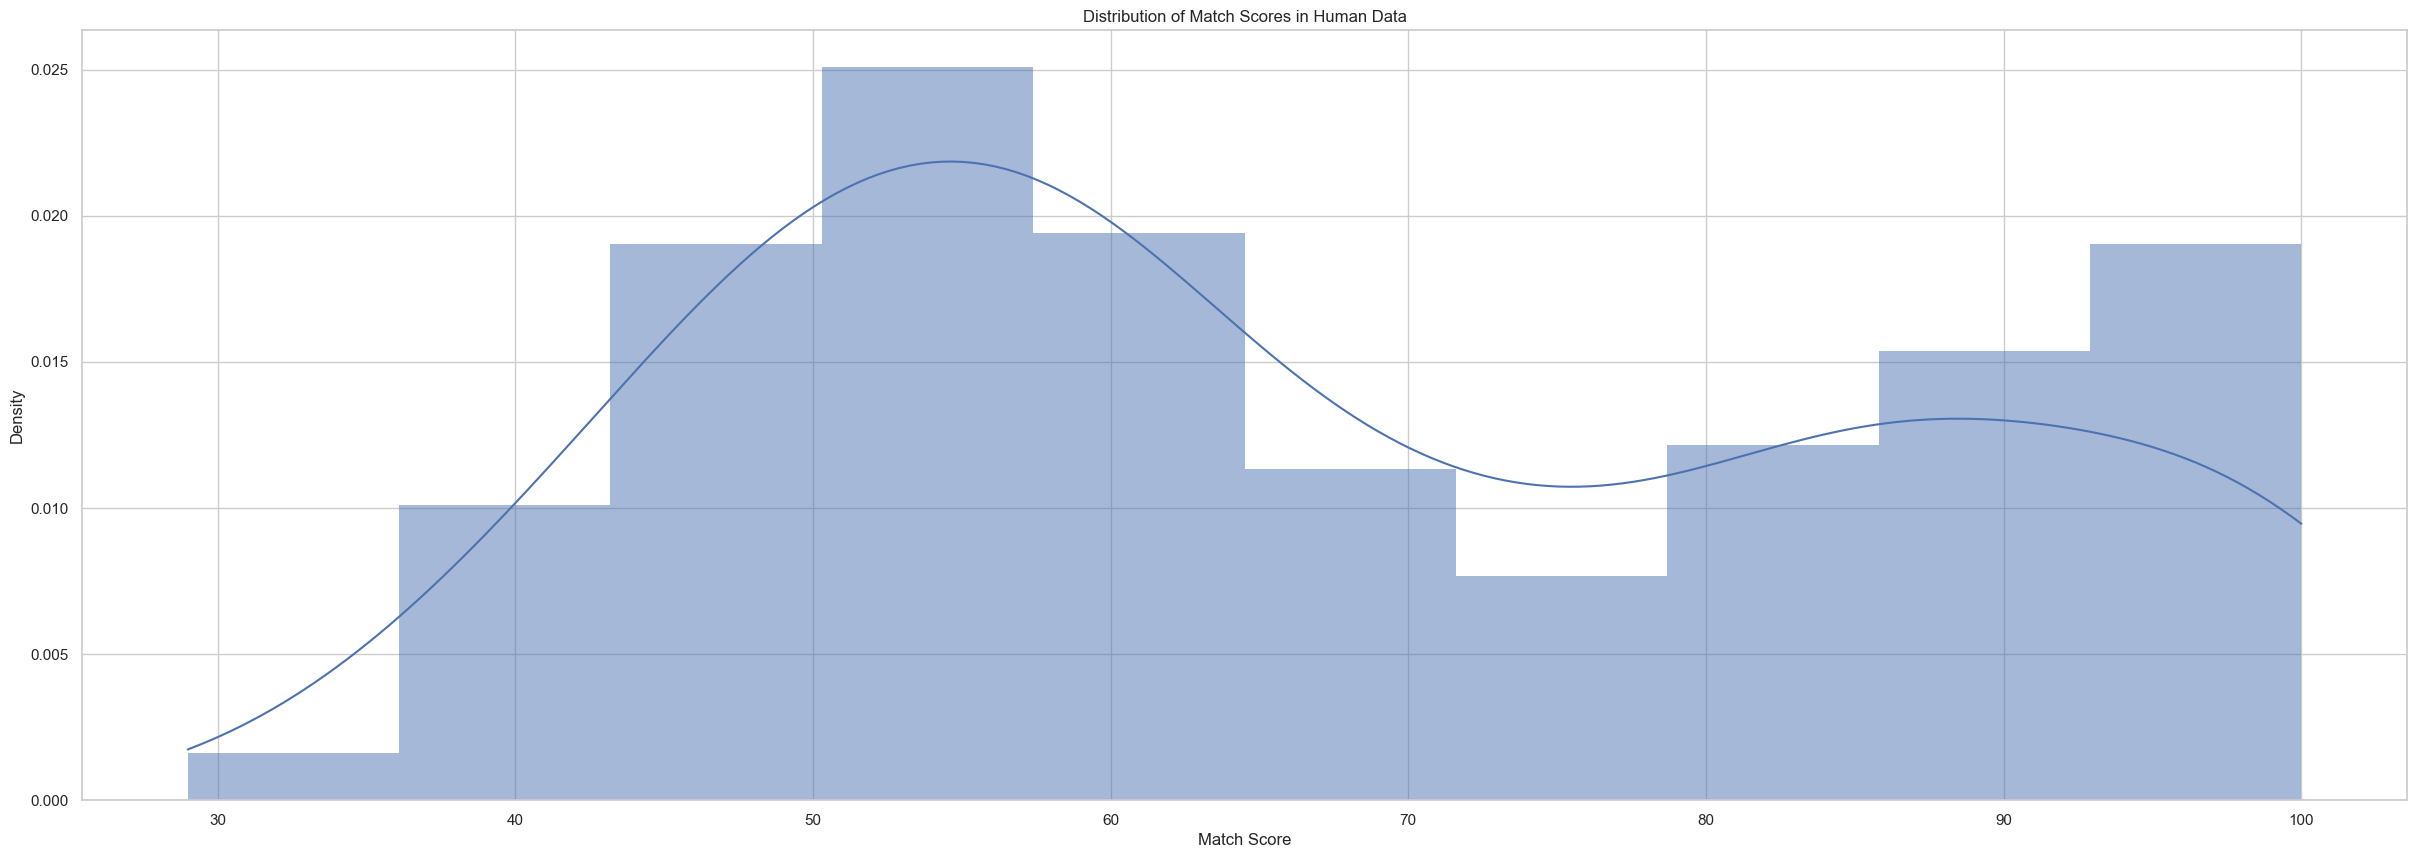

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Calculate the standard deviation of the 'match_score' column in human_data
std_deviation = human_data['match_score'].std()

# Calculate the average of the 'match_score' column in human_data
average_match_score = human_data['match_score'].mean()

# Print the average match score
print("Average of 'match_score':", average_match_score)

# Calculate specific percentiles of the 'match_score' column in human_data
percentile_25 = human_data['match_score'].quantile(0.25)
percentile_50 = human_data['match_score'].quantile(0.50)  # This is the median
percentile_75 = human_data['match_score'].quantile(0.75)

# Print the percentile values
print("25th Percentile of 'match_score':", percentile_25)
print("Median (50th Percentile) of 'match_score':", percentile_50)
print("75th Percentile of 'match_score':", percentile_75)

# Calculate the median of the 'match_score' column in human_data
median_match_score = human_data['match_score'].median()

# Print the median match score
print("Median of 'match' score':", median_match_score)

# Print the standard deviation
print("Standard Deviation of 'match_score':", std_deviation)

# Setting the style and color palette of the plot
sns.set(style="whitegrid")

# Creating the density plot for match_score distribution in human_data
plt.figure(figsize=(30, 10))
sns.histplot(human_data['match_score'], kde=True, stat="density", linewidth=0)

# Adding titles and labels
plt.title('Distribution of Match Scores in Human Data')
plt.xlabel('Match Score')
plt.ylabel('Density')

# Display the plot
plt.show()


# LLM: This concatenates everything in filtered_data into a string then compares

In [27]:
from fuzzywuzzy import fuzz
import pandas as pd

# Define a function to compute fuzzy match score between two rows, using only selected columns
def compute_fuzzy_match(row1, human_data):
    # Convert selected entries to string and concatenate
    row1_str = ' '.join(map(str, row1[columns_to_compare]))
    
    max_score = 0  # Initialize max score
    
    # Loop over each row in human_data to find the highest match score
    for index, row2 in human_data.iterrows():
        # Concatenate only the selected columns for comparison
        row2_str = ' '.join(map(str, row2[columns_to_compare]))
        score = fuzz.ratio(row1_str, row2_str)  # Compute the match score
        #print(row1_str,row2_str)
        if score > max_score:
            max_score = score  # Update the max score if current score is higher
    
    return max_score

# Apply the function row-wise and create a new column for scores in filtered_data
filtered_data['match_score'] = filtered_data.apply(compute_fuzzy_match, axis=1, args=(human_data,))

# Display the updated filtered_data DataFrame
print(filtered_data)


     konsert_datum                                    konsert_namn  \
0         14.02.08                  vivien chartres afskedskonsert   
1         13.02.08                            kullor ållon konsert   
2         13.02.08                                    stop konsert   
3         18.01.08         konsert för wennerbergsstoden i uppsala   
4                                        konsert av fru h. peizold   
...            ...                                             ...   
1194      06.09.08                                  circus orlando   
1195      06.09.08                 schwarzmanoffs orkester konsert   
1196      06.09.08                konsert af solist kapellet freya   
1197      06.09.08                          middags & aftonkonsert   
1198      06.09.08  kalle halldén stråkkapell kaffe & aftonkonsert   

                                 lokal_namn  \
0     kungliga musikaliska akademiens lokal   
1                           restaurang metr   
2                 

# Statistics for filtered_data

In [56]:
# Calculate the standard deviation of the 'match_score' column
std_deviation = filtered_data['match_score'].std()

# Calculate the average of the 'match_score' column
average_match_score = filtered_data['match_score'].mean()

# Print the average match score
print("Average of 'match_score':", average_match_score)

# Calculate specific percentiles of the 'match_score' column
percentile_25 = filtered_data['match_score'].quantile(0.25)
percentile_50 = filtered_data['match_score'].quantile(0.50)  # This is the median
percentile_75 = filtered_data['match_score'].quantile(0.75)

# Print the percentile values
print("25th Percentile of 'match_score':", percentile_25)
print("Median (50th Percentile) of 'match_score':", percentile_50)
print("75th Percentile of 'match_score':", percentile_75)

# Calculate the median of the 'match_score' column
median_match_score = filtered_data['match_score'].median()

# Print the median match score
print("Median of 'match_score':", median_match_score)


# Print the standard deviation
print("Standard Deviation of 'match_score':", std_deviation)


Average of 'match_score': 56.38125
25th Percentile of 'match_score': 44.0
Median (50th Percentile) of 'match_score': 52.0
75th Percentile of 'match_score': 65.25
Median of 'match_score': 52.0
Standard Deviation of 'match_score': 16.714250149482265


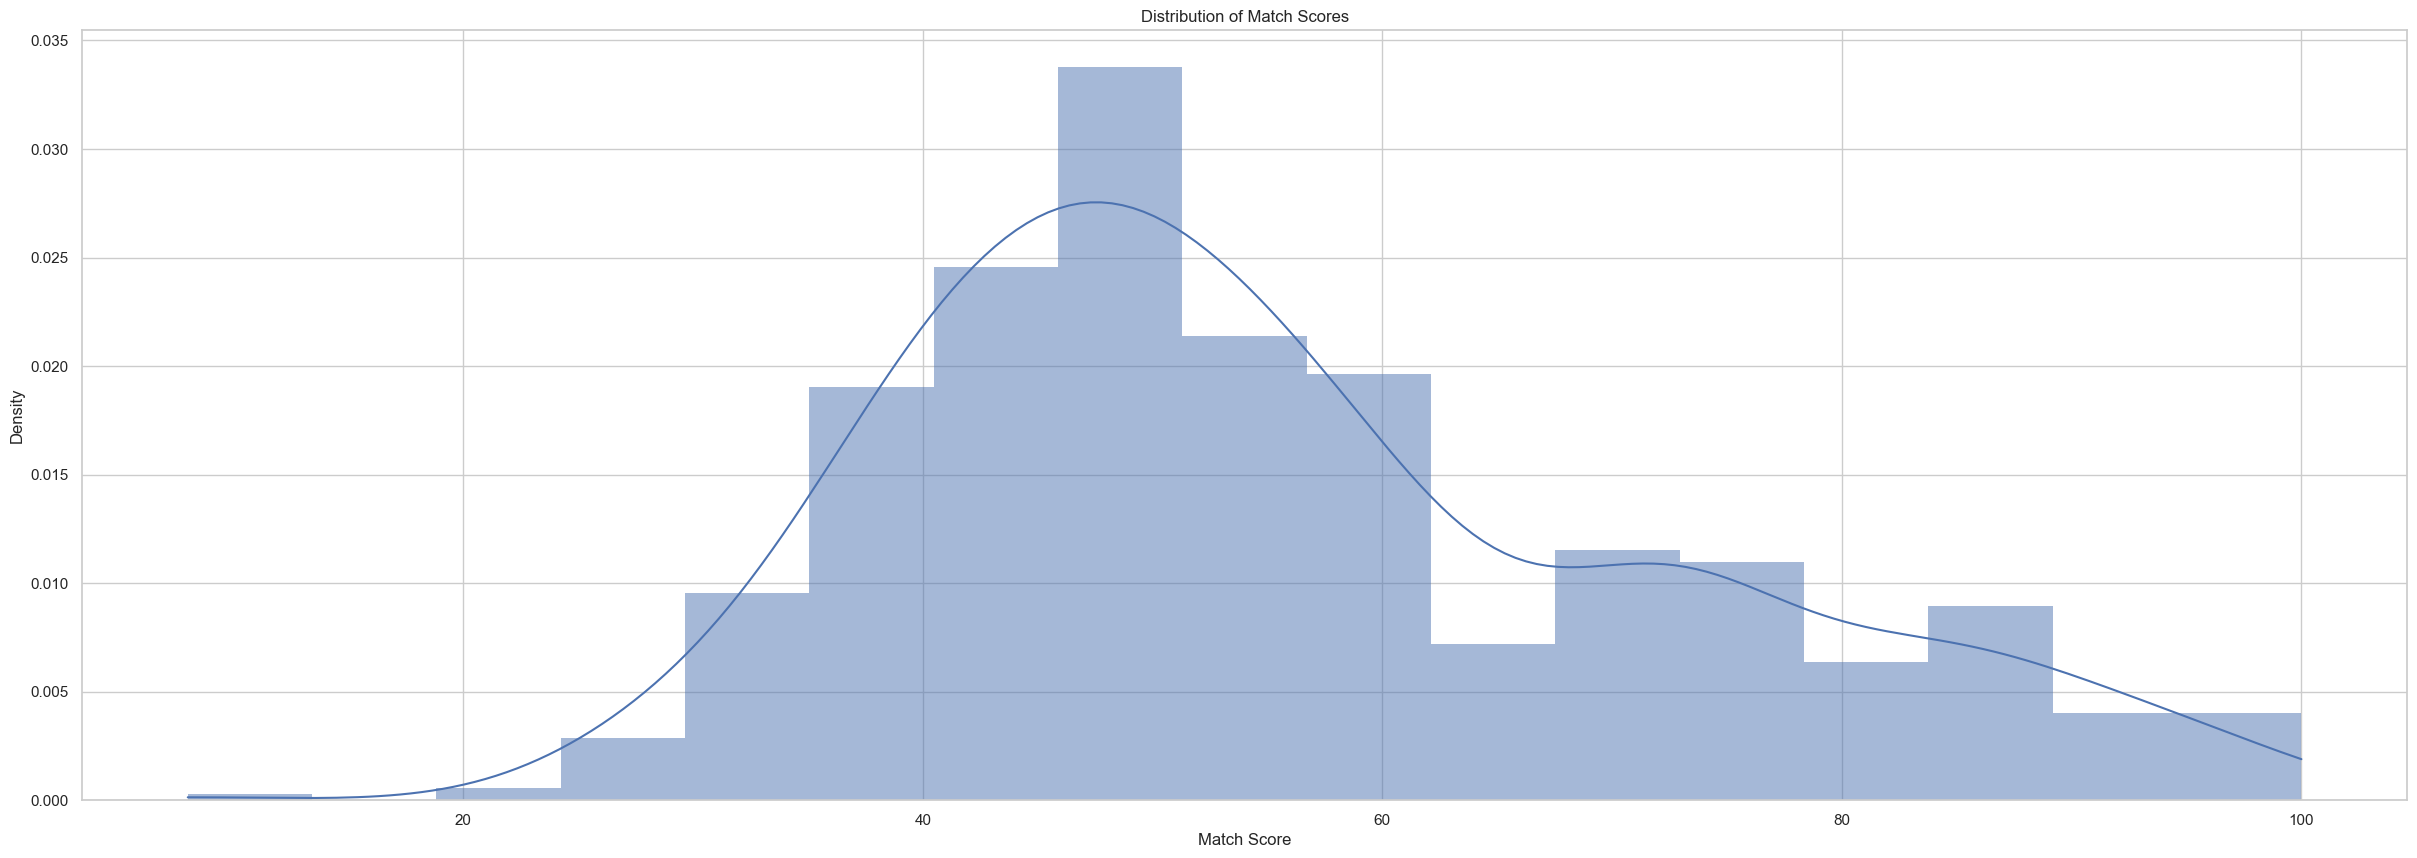

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
# Setting the style and color palette of the plot
sns.set(style="whitegrid")

# Creating the density plot
plt.figure(figsize=(30, 10))
sns.histplot(filtered_data['match_score'], kde=True, stat="density", linewidth=0)

# Adding titles and labels
plt.title('Distribution of Match Scores')
plt.xlabel('Match Score')
plt.ylabel('Density')

# Display the plot
plt.show()
